# MultiLayer Perceptron (MLP) Model for Optical Character Recognition (OCR)

Code written by: Femi Kuponu

Date:20/07/2018

### Import all the needed libraries

In [1]:
from IPython.display import Image
from __future__ import print_function 
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import sys
import cntk as C
import time

%matplotlib inline

In [2]:
# Perform some initialization
# using the cpu as the target device
C.device.try_set_default_device(C.device.cpu())

# Ensure we always get the same amount of randomness
np.random.seed(9)
C.cntk_py.set_fixed_random_seed(10)
C.cntk_py.force_deterministic_algorithms()

### Read Data

In deep learning modeling the data often may not fit into memory (RAM). For this case, CNTK provides the MinibatchSource class.
Note, the class cntk.io.MinibatchSource uses CTFDeserializer, enables randomization and specifies number of sweeps to be made through the data. In deep learning, we take small randomly sampled instances of data and update the parameters of the model in an iterative manner. Making multiple passes through the data often improves the performance of a model as it learns to cope up with different instances of randomly sampled data. This makes specification of the number of sweeps important. In this case, since the data set is relatively small we set the value to cntk.io.INFINITELY_REPEAT. In case, you are faced with very large data sets and CPU memory pressure is high, reducing the size of the randomization window in chunks (randomization_window_in_chunks) can help in dealing with memory resource utilization.

In [3]:
#Define the file paths
TrainData_path = 'data\\MNIST\\Train-28x28_cntk_text.txt'
ValidationData_path = 'data\\MNIST\\val-28x28_cntk_text.txt'
TestData_path = 'data\\MNIST\\Test-28x28_cntk_text.txt'

In [4]:
# Read a CTF formatted text (as mentioned above) using the CTF deserializer from a file
def create_reader(path, is_training, input_dim, num_label_classes):
    
    labelStream = C.io.StreamDef(field='labels', shape=num_label_classes, is_sparse=False)
    featureStream = C.io.StreamDef(field='features', shape=input_dim, is_sparse=False)
    
    deserailizer = C.io.CTFDeserializer(path, C.io.StreamDefs(labels = labelStream, features = featureStream))
            
    return C.io.MinibatchSource(deserailizer,
       randomize = is_training, max_sweeps = C.io.INFINITELY_REPEAT if is_training else 1)

### Build the MLP Model

In [5]:
# Define the network
input_dim = 784               # corresponds to the length of the flattened image of dimension 28x28
num_output_classes = 10       # number of digits (0-9) in the dataset/labels

# The CNTK requires input variable that holds the observations for training and testing 
input_features = C.input_variable(input_dim)
label= C.input_variable(num_output_classes)

#Normalize the input values to a scale 0-1
input_norm= input_features/255

#define the number of hidden layers
num_hidden_layers = 2
#define the dimension of each hidden layer
hidden_layers_dim = np.array([400, 200])
# define the Multi Layer Perceptron model using Dense function as a weighted sum of the input and the bias. a relu activation
# function is used for the hiden layers. No activation function on the output, as it will be passed through the softmax function 
#in the next step
def create_model(features):
    with C.layers.default_options(init = C.layers.glorot_uniform(), activation = C.ops.relu):
            h = features
            for kk in range(num_hidden_layers):
                h = C.layers.Dense(hidden_layers_dim[kk-1])(h)
            r = C.layers.Dense(num_output_classes, activation = None)(h)
            return r
# Call the model function to pass the input features through and predict and output
y_hat = create_model(input_norm)

# Use the c entropy and classification error as the performance index for the model built. 
# A softmax activation function is used to give the output probability interpretation.
loss = C.cross_entropy_with_softmax(y_hat, label)
label_error = C.classification_error(y_hat, label)

### Model Training with the data

The minibatch gradient descent is used during training to achive the optimal/close to optimal parameters for the Multi Layer Perceptron model

In [6]:
# Create the reader to training data set
reader_train = create_reader(TrainData_path, True, input_dim, num_output_classes)

# Map the data streams to the input and labels.
input_map = {label  : reader_train.streams.labels, input_features  : reader_train.streams.features} 

In [7]:
# Instantiate the trainer object to drive the model training
learning_rate = 0.2
lr_schedule = C.learning_rate_schedule(learning_rate, C.UnitType.minibatch)
learner = C.sgd(y_hat.parameters, lr_schedule)
#trainer = C.Trainer(y_hat, (loss, label_error), [learner])
trainer = C.Trainer(y_hat, (loss, label_error), learner)

# initialize the parameters for the trainer
minibatch_size = 64
num_samples_per_sweep = 60000
num_sweeps_to_train_with = 10
num_minibatches_to_train = (num_samples_per_sweep * num_sweeps_to_train_with) / minibatch_size

In [8]:
# Defines a utility that prints the training progress
def print_training_progress(trainer, mb, frequency, verbose=1):
    training_loss = "NA"
    eval_error = "NA"

    if mb%frequency == 0:
        training_loss = trainer.previous_minibatch_loss_average
        eval_error = trainer.previous_minibatch_evaluation_average
        if verbose: 
            print ("Minibatch: {0}, Loss: {1:.4f}, Error: {2:.2f}%".format(mb, training_loss, eval_error*100))
        
    return mb, training_loss, eval_error

training_progress_output_freq = 500

plotdata = {"batchsize":[], "loss_function":[], "Classification_error":[]}


In [9]:
# Start a timer
start = time.time()
for epoch in range(0, int(num_minibatches_to_train)):
    
    # Read a mini batch from the training data file
    data = reader_train.next_minibatch(minibatch_size, input_map = input_map)
    
    trainer.train_minibatch(data)
    batchsize, loss, error = print_training_progress(trainer, epoch, training_progress_output_freq, verbose=1)
    
    if not (loss == "NA" or error =="NA"):
        plotdata["batchsize"].append(batchsize)
        plotdata["loss_function"].append(loss)
        plotdata["Classification_error"].append(error)
# Print training time
print("The Model Training took {:.1f} mins".format((time.time() - start)/60))


Minibatch: 0, Loss: 2.3297, Error: 93.75%
Minibatch: 500, Loss: 0.3087, Error: 9.38%
Minibatch: 1000, Loss: 0.0945, Error: 1.56%
Minibatch: 1500, Loss: 0.1409, Error: 4.69%
Minibatch: 2000, Loss: 0.0161, Error: 0.00%
Minibatch: 2500, Loss: 0.0285, Error: 1.56%
Minibatch: 3000, Loss: 0.0079, Error: 0.00%
Minibatch: 3500, Loss: 0.0530, Error: 1.56%
Minibatch: 4000, Loss: 0.0285, Error: 1.56%
Minibatch: 4500, Loss: 0.0288, Error: 0.00%
Minibatch: 5000, Loss: 0.0054, Error: 0.00%
Minibatch: 5500, Loss: 0.0076, Error: 0.00%
Minibatch: 6000, Loss: 0.0073, Error: 0.00%
Minibatch: 6500, Loss: 0.0179, Error: 0.00%
Minibatch: 7000, Loss: 0.0148, Error: 0.00%
Minibatch: 7500, Loss: 0.0111, Error: 0.00%
Minibatch: 8000, Loss: 0.0017, Error: 0.00%
Minibatch: 8500, Loss: 0.0043, Error: 0.00%
Minibatch: 9000, Loss: 0.0044, Error: 0.00%
The Model Training took 3.1 mins


## Data Visualization


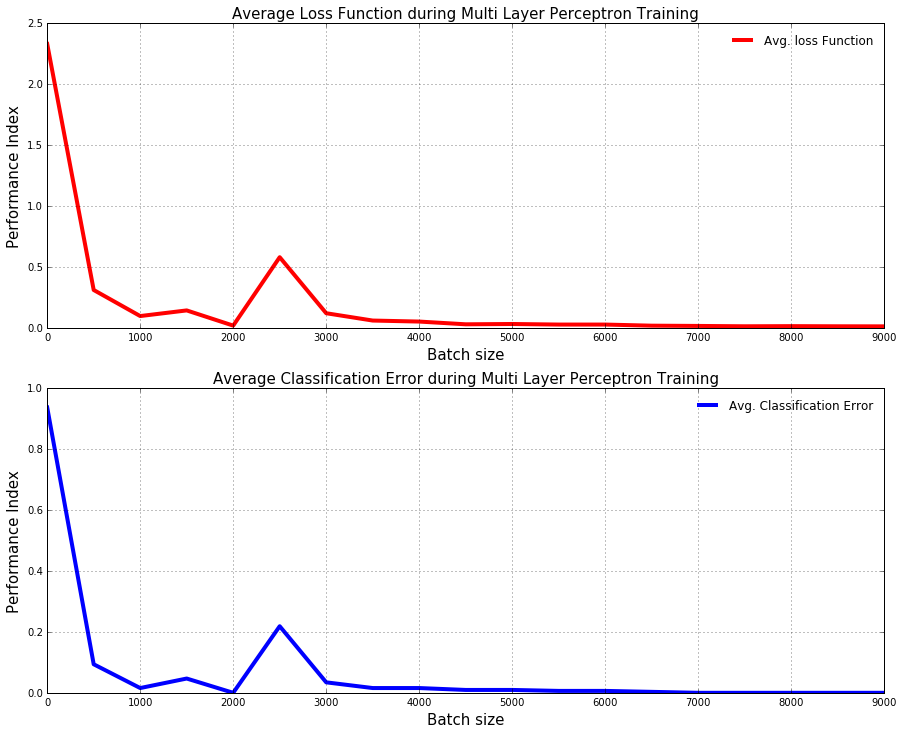

In [10]:
# Define a utility function to compute the moving average sum.
# A more efficient implementation is possible with np.cumsum() function

def moving_average(a, w=5):
    if len(a) < w:
        return a[:]    # Need to send a copy of the array
    return [val if idx < w else sum(a[(idx-w):idx])/w for idx, val in enumerate(a)]

# create new columns to hold the average loss function and average classification error
plotdata["AvglossFunction"] = moving_average(plotdata["loss_function"])
plotdata["AvgClassificationError"] = moving_average(plotdata["Classification_error"])

# note the %matplotlib inline as bee defined in the first cell
plt.figure(1,figsize =(15,12))
plt.subplot(211)
plt.title('Average Loss Function during Multi Layer Perceptron Training',fontsize=15)
plt.plot(plotdata["batchsize"],plotdata["AvglossFunction"],'r',linewidth=4)
plt.legend(['Avg. loss Function'],frameon=False)
plt.ylabel('Performance Index',fontsize=15)
plt.xlabel('Batch size',fontsize=15)
plt.grid()
plt.subplot(212)
plt.title('Average Classification Error during Multi Layer Perceptron Training',fontsize=15)
plt.plot(plotdata["batchsize"],plotdata["AvgClassificationError"],'b-',linewidth=4)
plt.grid()
plt.legend(['Avg. Classification Error'],frameon=False)
plt.ylabel('Performance Index',fontsize=15)
plt.xlabel('Batch size',fontsize=15)
plt.show()


## Model Validation using Validation Data

In [11]:
# Read the validation dataset
reader_val = create_reader(ValidationData_path, False, input_dim, num_output_classes)

val_input_map = {
    label  : reader_val.streams.labels,
    input_features  : reader_val.streams.features,
}

# validate data for trained model
val_minibatch_size = 512
num_samples = 9488
num_minibatches_to_val = int(num_samples / val_minibatch_size)
Overall_Validation_error = 0.0

for i in range((num_minibatches_to_val)):
    
    data = reader_val.next_minibatch(val_minibatch_size, input_map = val_input_map)

    Val_error = trainer.test_minibatch(data)
    Overall_Validation_error += Val_error

# Average of evaluation errors of all test minibatches
print("Average validation error of the model is : {0:.2f}%" .format(Overall_Validation_error*100 / num_minibatches_to_val))


Average validation error of the model is : 2.00%


## Model Validation using Testing Data

A new set of data was introduced as the testing dataset for an unbiased performance evaluation. Now, we visualize the outcome

In [12]:
# Read the testing dataset
reader_test = create_reader(TestData_path, False, input_dim, num_output_classes)

test_input_map = {
    label  : reader_test.streams.labels,
    input_features  : reader_test.streams.features,
}

data = reader_test.next_minibatch(512, input_map = test_input_map)
Testing_error = trainer.test_minibatch(data)
# Average of evaluation errors of all test minibatches
print("Average test error of the model is : {0:.2f}%" .format(Testing_error*100))


Average test error of the model is : 3.71%


In [13]:
#Lets predict and output the labels and predicted values of the testing set
out = C.softmax(y_hat)
img_data = data[input_features].asarray()
predicted_label_prob=out.eval(img_data)
pred_label= np.transpose([np.argmax(predicted_label_prob[i]) for i in range(len(predicted_label_prob))])


img_label = data[label].asarray()
act_label= np.transpose([np.argmax(img_label[i]) for i in range(len(img_label))])


print("+--------------------------------------Actual label vs Predicted label----------------------------------------+")
print("| Hand Written/optical Character: {0} |".format(act_label[0:37]))
print("| Predicted Character           : {0} |".format(pred_label[:37]))
print("+-------------------------------------------------------------------------------------------------------------+")
print("| Hand Written/optical Character: {0} |".format(act_label[38:75]))
print("| Predicted Character           : {0} |".format(pred_label[38:75]))
print("+-------------------------------------------------------------------------------------------------------------+")
print("| Hand Written/optical Character: {0} |".format(act_label[76:113]))
print("| Predicted Character           : {0} |".format(pred_label[76:113]))
print("+-------------------------------------------------------------------------------------------------------------+")
print("| Hand Written/optical Character: {0} |".format(act_label[-37:]))
print("| Predicted Character           : {0} |".format(pred_label[-37:]))
print("+-------------------------------------------------------------------------------------------------------------+")

+--------------------------------------Actual label vs Predicted label----------------------------------------+
| Hand Written/optical Character: [0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 1 0 1 2 7 5 3] |
| Predicted Character           : [0 1 2 3 4 5 6 7 8 9 0 1 7 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 1 0 1 2 7 5 3] |
+-------------------------------------------------------------------------------------------------------------+
| Hand Written/optical Character: [4 0 0 6 9 6 6 5 7 2 3 4 4 9 1 4 0 7 9 5 7 2 3 1 4 4 0 9 9 6 1 8 3 3 7 3 9] |
| Predicted Character           : [4 0 0 6 9 6 6 5 7 2 3 4 4 9 1 4 0 7 9 5 7 2 3 1 4 4 0 9 9 6 1 8 3 3 7 3 9] |
+-------------------------------------------------------------------------------------------------------------+
| Hand Written/optical Character: [8 4 7 7 6 2 1 9 8 7 8 8 7 2 2 3 9 3 3 5 5 0 7 9 5 6 5 1 4 1 1 2 8 2 6 1 5] |
| Predicted Character           : [8 4 7 7 6 2 1 9 8 7 8 8 7 2 2 3 9 3 3 5 5 0 7 4 5 6 5 1 4 1 1 2 8 2 6

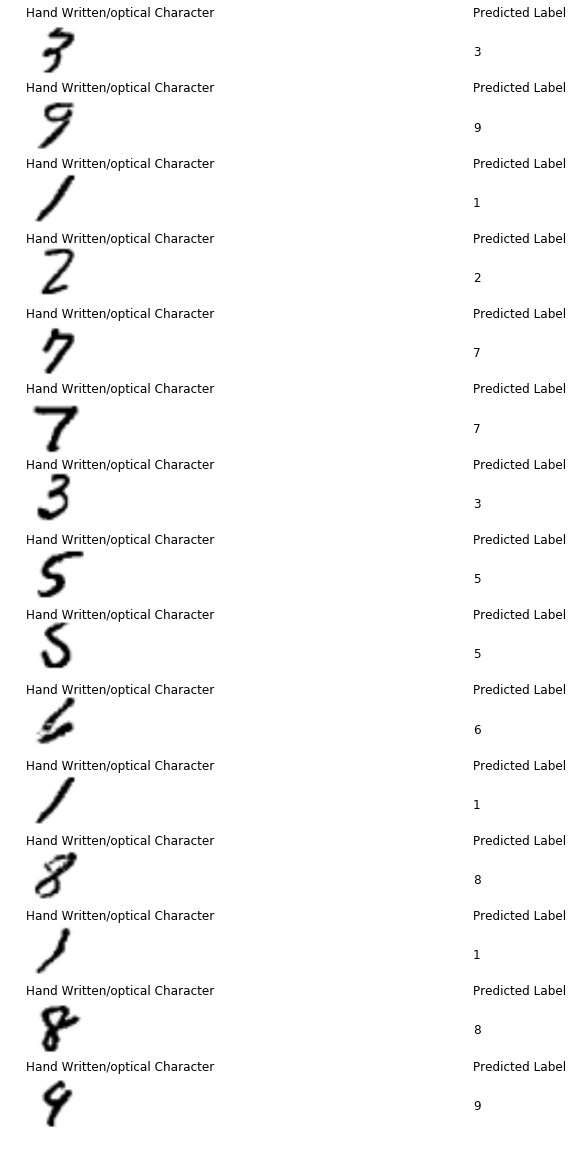

In [14]:
# Another view of the predicted values and label
np.random.seed(34)
sample_num = np.random.randint(0,512,15)
plt.figure(1, figsize=(20,20))

for i in range(len(sample_num)):
    plt.subplot(len(sample_num),1,i+1)
    plt.imshow(img_data[sample_num[i]].reshape(28,28), cmap="gray_r")
    plt.axis('off')
    plt.text(200, 0.5, 'Predicted Label', fontsize=12)
    plt.text(200, 18, pred_label[sample_num[i]], fontsize=12)
    plt.text(0.5, 0.5, 'Hand Written/optical Character', fontsize=12)
    

# reseed to 9
np.random.seed(9)


## Further Prediction with new dataset/image

Predicted Label of first character : 2
Predicted Label of second character: 0


(-0.5, 27.5, 27.5, -0.5)

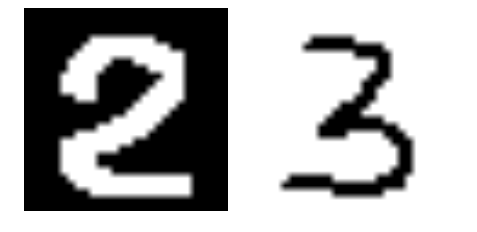

In [15]:
from PIL import Image as img
im = img.open("data\\MNIST\\MysteryNumberD.bmp")
im1 = img.open("data\\MNIST\\testing1.bmp")

pix_val = im.getdata()
pix_val1 = im1.getdata()

pp=[pix_val,pix_val1]
k=np.array(pp).astype('float32')
predicted_label_prob=out.eval(k)
pred_label= [np.argmax(predicted_label_prob[i]) for i in range(len(predicted_label_prob))]
print("Predicted Label of first character : {0}".format(pred_label[0]))
print("Predicted Label of second character: {0}".format(pred_label[1]))

plt.figure(2,figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(im)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(im1)
plt.axis('off')


## Remarks:

A Multi Layer Perceptron model have been implemented for Optical Character Recognition (OCR).
This involved flattening the image and passing it through the model. The model parameters were chosen using gradent descent, precisely the minibatch. The validation data set was used during training to validate and choose the best model, while the testing dataset evaluates the performance of the chosen model. Based on the testing set error achieved, the MLP mdel performs better than the multiclass LR model, though some characters were wrongly predicted. A Convolutional Neural Network (CNN) model is investigated to improve prediction of OCR. 

#### Note:
With a little tweaking, this code can be used for any classification problem. 
#### Reference
[1] http://yann.lecun.com/exdb/mnist/

[2] https://cntk.ai/pythondocs/tutorials.html

[3] https://gallery.azure.ai/Tutorial/Cognitive-Toolkit-101-Logistic-Regression-and-ML-Primer

End of Simulation